## 讀取資料

In [262]:
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

df = pd.read_csv("emotion_gpt.csv")

# 確認欄位
print("Columns:", df.columns)

Columns: Index(['emotion_id', 'article_id', 'entity', 'entity_type', 'asian_status',
       'emotion', 'emotion_reason', 'date'],
      dtype='object')


In [263]:
df.head()

,emotion_id,article_id,entity,entity_type,asian_status,emotion,emotion_reason,date
0,emotion_1,Article_1,"Julie Morita, M.D.",professionals,Asian,cannot be inferred,"Julie Morita, M.D., is executive vice presiden...",2020-04-21
1,emotion_2,Article_1,Japanese Americans,victims,Asian,sadness,"As Japanese Americans, they experienced as chi...",2020-04-21
2,emotion_3,Article_1,Asian Americans,victims,Asian,anger,"With the coronavirus pandemic today, they are ...",2020-04-21
3,emotion_4,Article_1,Asian Americans,victims,Asian,anger,"Now, I must speak out in the face of new attac...",2020-04-21
4,emotion_5,Article_1,Asian Americans,victims,Asian,anger,The percentage of tweets involving negative sp...,2020-04-21


## Preprocess - Mainstream v.s Non-Mainstream

In [265]:
# 1) 讀取 Excel (id 對應 media_type)
excel_df = pd.read_excel('articles_584.xlsx', usecols=['id', 'media_type'])
id_to_media = dict(zip(excel_df['id'], excel_df['media_type']))

# 2) 從 article_id 提取數字部分，轉成整數
df['article_num'] = df['article_id'].str.extract(r'(\d+)').astype(int)

# 3) 用 mapping 加上 mainstream / nonmainstream 欄位
df['media_group'] = df['article_num'].map(id_to_media).fillna('unknown')
df['mainstream'] = df['media_group'].map({'mainstream': "1", 'nonmainstream': "0"})

# 4) 存回新檔
df.to_csv('emotion_gpt_with_media.csv', index=False, encoding='utf-8-sig')

print("✅ Done! 已新增欄位 'media_group' (mainstream / nonmainstream)")

✅ Done! 已新增欄位 'media_group' (mainstream / nonmainstream)


In [266]:
df.head()

,emotion_id,article_id,entity,entity_type,asian_status,emotion,emotion_reason,date,article_num,media_group,mainstream
0,emotion_1,Article_1,"Julie Morita, M.D.",professionals,Asian,cannot be inferred,"Julie Morita, M.D., is executive vice presiden...",2020-04-21,1,mainstream,1
1,emotion_2,Article_1,Japanese Americans,victims,Asian,sadness,"As Japanese Americans, they experienced as chi...",2020-04-21,1,mainstream,1
2,emotion_3,Article_1,Asian Americans,victims,Asian,anger,"With the coronavirus pandemic today, they are ...",2020-04-21,1,mainstream,1
3,emotion_4,Article_1,Asian Americans,victims,Asian,anger,"Now, I must speak out in the face of new attac...",2020-04-21,1,mainstream,1
4,emotion_5,Article_1,Asian Americans,victims,Asian,anger,The percentage of tweets involving negative sp...,2020-04-21,1,mainstream,1


## 定義 source type

In [268]:
source_type_cols = [
    'politicians', 'professionals', 'celebrities', 'perpetrators', 'victims',
    'other_individuals', 'law_enforcement_agencies', 'government_bodies',
    'ngo_or_advocacy_groups', 'business_entities', 'community_groups'
]

individual_cols = [
    'politicians', 'professionals', 'celebrities',
    'perpetrators', 'victims', 'other_individuals'
]

organization_cols = [
    'law_enforcement_agencies', 'government_bodies',
    'ngo_or_advocacy_group', 'business_entities', 'community_groups'
]

## Victim 情緒分析

### 次數／比例分析

In [271]:
# 篩選條件
target_emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
filtered = df[
    (df['entity_type'] == 'victims') &
    (df['emotion'].isin(target_emotions))
]

# 統計各情緒的次數
emotion_counts = (
    filtered.groupby(['media_group', 'emotion'])
    .size()
    .reset_index(name='count')
)

# 計算比例
# 在同一個媒體（ mainstream 或 nonmainstream ）內，各個情緒的出現次數相對於該媒體的總情緒次數的比例
emotion_counts['percentage'] = (
    emotion_counts.groupby('media_group')['count']
    .transform(lambda x: round(100 * x / x.sum(), 2))
)

emotion_counts

,media_group,emotion,count,percentage
0,mainstream,anger,103,18.93
1,mainstream,fear,175,32.17
2,mainstream,joy,16,2.94
3,mainstream,love,4,0.74
4,mainstream,sadness,246,45.22
5,non-mainstream,anger,214,18.24
6,non-mainstream,fear,364,31.03
7,non-mainstream,joy,16,1.36
8,non-mainstream,love,21,1.79
9,non-mainstream,sadness,558,47.57


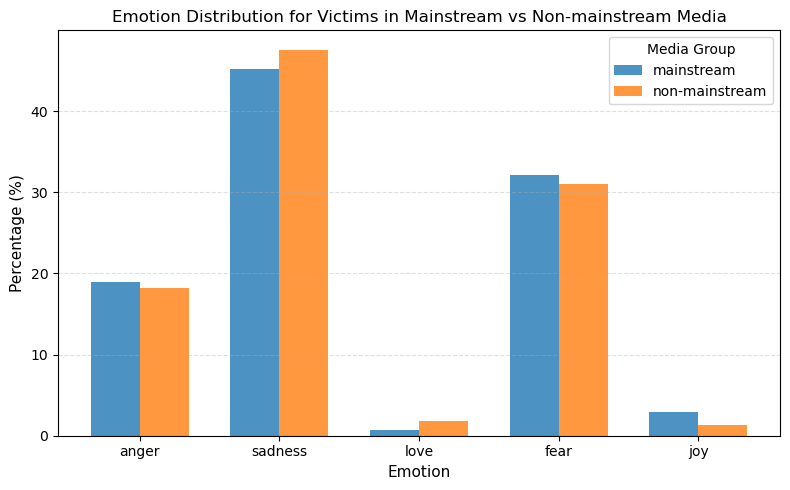

In [272]:
import matplotlib.pyplot as plt
import numpy as np

# 確保情緒順序固定（避免亂序）
emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
media_groups = emotion_counts['media_group'].unique()

# 建立 x 軸位置
x = np.arange(len(emotions))
bar_width = 0.35  # 每個長條寬度

plt.figure(figsize=(8, 5))

for i, group in enumerate(media_groups):
    subset = emotion_counts[emotion_counts['media_group'] == group].set_index('emotion').reindex(emotions).fillna(0)
    plt.bar(x + i * bar_width, subset['percentage'], width=bar_width, label=group, alpha=0.8)

# 美化圖表
plt.title("Emotion Distribution for Victims in Mainstream vs Non-mainstream Media", fontsize=12)
plt.xlabel("Emotion", fontsize=11)
plt.ylabel("Percentage (%)", fontsize=11)
plt.xticks(x + bar_width / 2, emotions)
plt.legend(title="Media Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 文章數 vs. 情緒出現數

In [274]:
# 每個媒體群組的文章數（unique article_id）
article_counts = filtered.groupby('media_group')['article_id'].nunique().reset_index(name='num_articles')

# 每個媒體群組的情緒出現總數
emotion_total = filtered.groupby('media_group').size().reset_index(name='num_emotions')

# 合併比較
summary = pd.merge(article_counts, emotion_total, on='media_group')
summary['emotions_per_article'] = round(summary['num_emotions'] / summary['num_articles'], 2)
summary

,media_group,num_articles,num_emotions,emotions_per_article
0,mainstream,143,544,3.80
1,non-mainstream,389,1173,3.02


### 每篇文章出現情緒的覆蓋率

In [276]:
article_level = (
    filtered.groupby(['media_group', 'article_id', 'emotion'])
    .size()
    .reset_index()
)

# 每個媒體群組中，每種情緒出現的文章篇數
article_emotion_counts = (
    article_level.groupby(['media_group', 'emotion'])
    .size()
    .reset_index(name='article_count')
)

# 該媒體總文章數
total_articles = (
    filtered.groupby('media_group')['article_id']
    .nunique()
    .reset_index(name='total_articles')
)

# 合併計算比例
article_emotion_counts = article_emotion_counts.merge(total_articles, on='media_group')
article_emotion_counts['article_ratio'] = round(
    100 * article_emotion_counts['article_count'] / article_emotion_counts['total_articles'], 2
)

article_emotion_counts

,media_group,emotion,article_count,total_articles,article_ratio
0,mainstream,anger,59,143,41.26
1,mainstream,fear,86,143,60.14
2,mainstream,joy,11,143,7.69
3,mainstream,love,4,143,2.80
4,mainstream,sadness,117,143,81.82
5,non-mainstream,anger,140,389,35.99
6,non-mainstream,fear,223,389,57.33
7,non-mainstream,joy,14,389,3.60
8,non-mainstream,love,9,389,2.31
9,non-mainstream,sadness,297,389,76.35


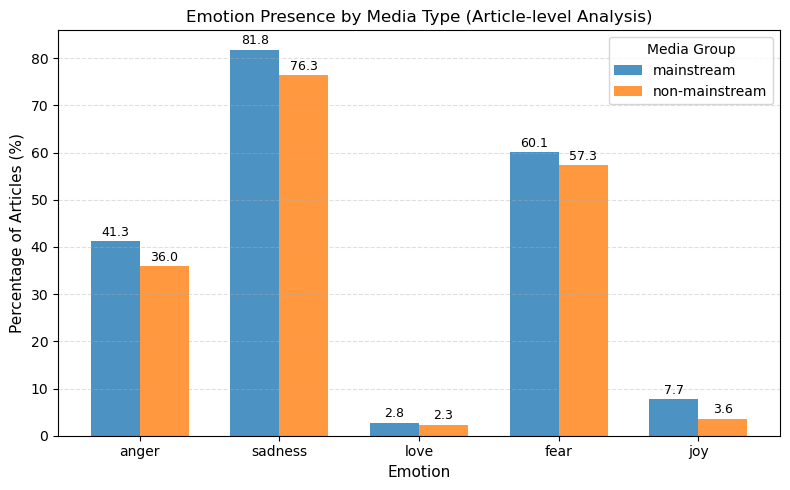

In [277]:
import matplotlib.pyplot as plt
import numpy as np

# 固定情緒順序，讓兩組對齊
emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
media_groups = article_emotion_counts['media_group'].unique()

# x 軸位置
x = np.arange(len(emotions))
bar_width = 0.35

plt.figure(figsize=(8, 5))

for i, group in enumerate(media_groups):
    subset = (
        article_emotion_counts[article_emotion_counts['media_group'] == group]
        .set_index('emotion')
        .reindex(emotions)
        .fillna(0)
    )
    plt.bar(x + i * bar_width, subset['article_ratio'], width=bar_width, label=group, alpha=0.8)

# 加上數值標籤
for i, group in enumerate(media_groups):
    subset = (
        article_emotion_counts[article_emotion_counts['media_group'] == group]
        .set_index('emotion')
        .reindex(emotions)
        .fillna(0)
    )
    for j, val in enumerate(subset['article_ratio']):
        plt.text(x[j] + i * bar_width, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

# 美化圖表
plt.title("Emotion Presence by Media Type (Article-level Analysis)", fontsize=12)
plt.xlabel("Emotion", fontsize=11)
plt.ylabel("Percentage of Articles (%)", fontsize=11)
plt.xticks(x + bar_width / 2, emotions)
plt.legend(title="Media Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 比例檢定（統計顯著性）

#### 文章出現比例

In [280]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

# 假設你前面已經建立好 article_emotion_counts
# 欄位包含：media_group, emotion, article_count, total_articles

# 建立結果列表
results = []

# 取得所有情緒
emotions = article_emotion_counts['emotion'].unique()

for emo in emotions:
    # 取出該情緒在兩種媒體群組的資料
    sub = article_emotion_counts[article_emotion_counts['emotion'] == emo]

    # 確保順序為 [mainstream, nonmainstream]
    sub = sub.set_index('media_group').reindex(['mainstream', 'non-mainstream'])
    
    count = sub['article_count'].values
    nobs = sub['total_articles'].values

    # 若資料不完整則跳過
    if len(count) < 2 or count[0] == 0 and count[1] == 0:
        continue

    # 執行比例 z 檢定
    z, p = proportions_ztest(count, nobs)

    results.append({
        'emotion': emo,
        'mainstream_ratio': round(100 * count[0] / nobs[0], 2),
        'nonmainstream_ratio': round(100 * count[1] / nobs[1], 2),
        'z_value': round(z, 3),
        'p_value': round(p, 4),
        'significant': 'Yes' if p < 0.05 else 'No'
    })

# 轉成 DataFrame
ztest_results = pd.DataFrame(results)
ztest_results

,emotion,mainstream_ratio,nonmainstream_ratio,z_value,p_value,significant
0,anger,41.26,35.99,1.113,0.2655,No
1,fear,60.14,57.33,0.583,0.5599,No
2,joy,7.69,3.60,1.978,0.0479,Yes
3,love,2.80,2.31,0.320,0.7488,No
4,sadness,81.82,76.35,1.346,0.1783,No


#### 出現總數比例

In [282]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

# 假設 emotion_counts 已經有以下欄位：
# ['media_group', 'emotion', 'count']

results = []

# 取得所有情緒種類
emotions = emotion_counts['emotion'].unique()

for emo in emotions:
    sub = emotion_counts[emotion_counts['emotion'] == emo].set_index('media_group')
    sub = sub.reindex(['mainstream', 'non-mainstream']).fillna(0)

    # 該情緒在不同媒體的出現次數
    count = sub['count'].values

    # 各媒體的總出現次數（母體數 = 該媒體內所有情緒的總次數）
    total = emotion_counts.groupby('media_group')['count'].sum().reindex(['mainstream', 'non-mainstream']).values

    # 若資料不完整則跳過
    if len(count) < 2 or total.sum() == 0:
        continue

    # 比例 z 檢定
    z, p = proportions_ztest(count, total)

    results.append({
        'emotion': emo,
        'mainstream_ratio': round(100 * count[0] / total[0], 2),
        'nonmainstream_ratio': round(100 * count[1] / total[1], 2),
        'z_value': round(z, 3),
        'p_value': round(p, 4),
        'significant': 'Yes' if p < 0.05 else 'No'
    })

# 結果整理
ztest_counts = pd.DataFrame(results)
ztest_counts

,emotion,mainstream_ratio,nonmainstream_ratio,z_value,p_value,significant
0,anger,18.93,18.24,0.343,0.7317,No
1,fear,32.17,31.03,0.473,0.6365,No
2,joy,2.94,1.36,2.248,0.0246,Yes
3,love,0.74,1.79,-1.698,0.0895,No
4,sadness,45.22,47.57,-0.908,0.3640,No


## Individuals 情緒分析

### 次數／比例分析

In [285]:
# 篩選條件
target_emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
filtered = df[
    (df['entity_type'].isin(individual_cols)) &
    (df['emotion'].isin(target_emotions))
]

# 統計各情緒的次數
emotion_counts = (
    filtered.groupby(['media_group', 'emotion'])
    .size()
    .reset_index(name='count')
)

# 計算比例
# 在同一個媒體（ mainstream 或 nonmainstream ）內，各個情緒的出現次數相對於該媒體的總情緒次數的比例
emotion_counts['percentage'] = (
    emotion_counts.groupby('media_group')['count']
    .transform(lambda x: round(100 * x / x.sum(), 2))
)

emotion_counts

,media_group,emotion,count,percentage
0,mainstream,anger,475,30.51
1,mainstream,fear,408,26.20
2,mainstream,joy,73,4.69
3,mainstream,love,39,2.50
4,mainstream,sadness,562,36.10
5,non-mainstream,anger,1118,33.28
6,non-mainstream,fear,843,25.10
7,non-mainstream,joy,122,3.63
8,non-mainstream,love,108,3.22
9,non-mainstream,sadness,1168,34.77


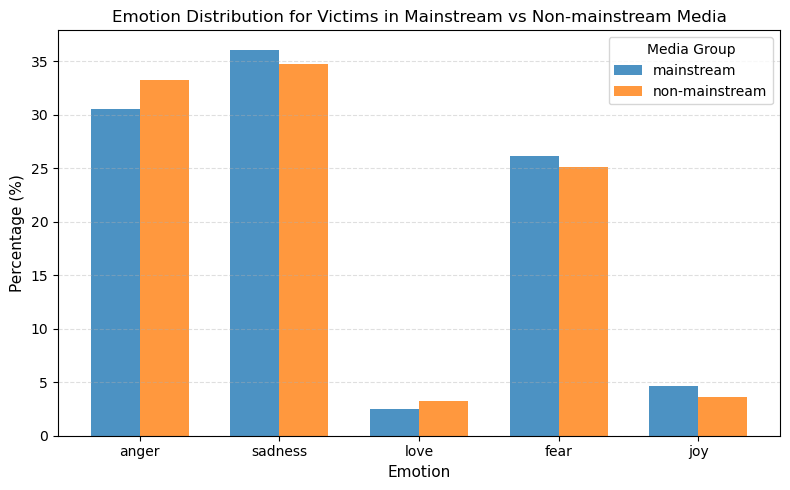

In [286]:
import matplotlib.pyplot as plt
import numpy as np

# 確保情緒順序固定（避免亂序）
emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
media_groups = emotion_counts['media_group'].unique()

# 建立 x 軸位置
x = np.arange(len(emotions))
bar_width = 0.35  # 每個長條寬度

plt.figure(figsize=(8, 5))

for i, group in enumerate(media_groups):
    subset = emotion_counts[emotion_counts['media_group'] == group].set_index('emotion').reindex(emotions).fillna(0)
    plt.bar(x + i * bar_width, subset['percentage'], width=bar_width, label=group, alpha=0.8)

# 美化圖表
plt.title("Emotion Distribution for Victims in Mainstream vs Non-mainstream Media", fontsize=12)
plt.xlabel("Emotion", fontsize=11)
plt.ylabel("Percentage (%)", fontsize=11)
plt.xticks(x + bar_width / 2, emotions)
plt.legend(title="Media Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 文章數 vs. 情緒出現數

In [288]:
# 每個媒體群組的文章數（unique article_id）
article_counts = filtered.groupby('media_group')['article_id'].nunique().reset_index(name='num_articles')

# 每個媒體群組的情緒出現總數
emotion_total = filtered.groupby('media_group').size().reset_index(name='num_emotions')

# 合併比較
summary = pd.merge(article_counts, emotion_total, on='media_group')
summary['emotions_per_article'] = round(summary['num_emotions'] / summary['num_articles'], 2)
summary

,media_group,num_articles,num_emotions,emotions_per_article
0,mainstream,155,1557,10.05
1,non-mainstream,427,3359,7.87


### 每篇文章出現情緒的覆蓋率

In [290]:
article_level = (
    filtered.groupby(['media_group', 'article_id', 'emotion'])
    .size()
    .reset_index()
)

# 每個媒體群組中，每種情緒出現的文章篇數
article_emotion_counts = (
    article_level.groupby(['media_group', 'emotion'])
    .size()
    .reset_index(name='article_count')
)

# 該媒體總文章數
total_articles = (
    filtered.groupby('media_group')['article_id']
    .nunique()
    .reset_index(name='total_articles')
)

# 合併計算比例
article_emotion_counts = article_emotion_counts.merge(total_articles, on='media_group')
article_emotion_counts['article_ratio'] = round(
    100 * article_emotion_counts['article_count'] / article_emotion_counts['total_articles'], 2
)

article_emotion_counts

,media_group,emotion,article_count,total_articles,article_ratio
0,mainstream,anger,142,155,91.61
1,mainstream,fear,131,155,84.52
2,mainstream,joy,43,155,27.74
3,mainstream,love,27,155,17.42
4,mainstream,sadness,148,155,95.48
5,non-mainstream,anger,393,427,92.04
6,non-mainstream,fear,349,427,81.73
7,non-mainstream,joy,83,427,19.44
8,non-mainstream,love,59,427,13.82
9,non-mainstream,sadness,397,427,92.97


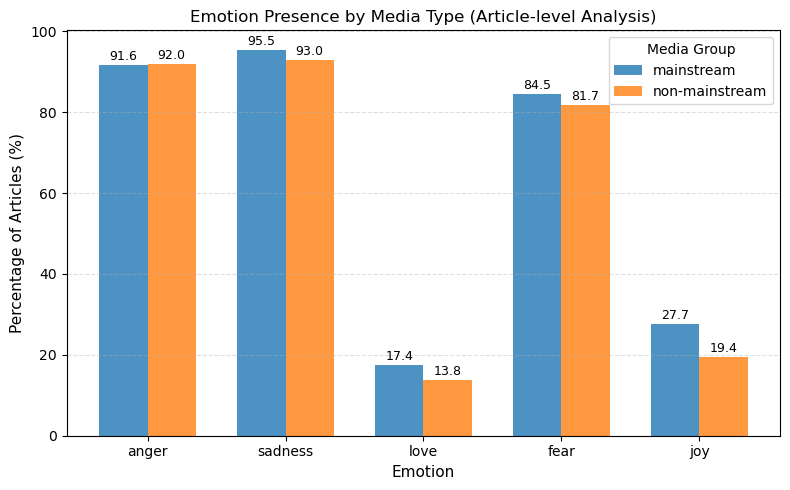

In [291]:
import matplotlib.pyplot as plt
import numpy as np

# 固定情緒順序，讓兩組對齊
emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
media_groups = article_emotion_counts['media_group'].unique()

# x 軸位置
x = np.arange(len(emotions))
bar_width = 0.35

plt.figure(figsize=(8, 5))

for i, group in enumerate(media_groups):
    subset = (
        article_emotion_counts[article_emotion_counts['media_group'] == group]
        .set_index('emotion')
        .reindex(emotions)
        .fillna(0)
    )
    plt.bar(x + i * bar_width, subset['article_ratio'], width=bar_width, label=group, alpha=0.8)

# 加上數值標籤
for i, group in enumerate(media_groups):
    subset = (
        article_emotion_counts[article_emotion_counts['media_group'] == group]
        .set_index('emotion')
        .reindex(emotions)
        .fillna(0)
    )
    for j, val in enumerate(subset['article_ratio']):
        plt.text(x[j] + i * bar_width, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

# 美化圖表
plt.title("Emotion Presence by Media Type (Article-level Analysis)", fontsize=12)
plt.xlabel("Emotion", fontsize=11)
plt.ylabel("Percentage of Articles (%)", fontsize=11)
plt.xticks(x + bar_width / 2, emotions)
plt.legend(title="Media Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 比例檢定（統計顯著性）

#### 文章出現比例

In [294]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

# 建立結果列表
results = []

# 取得所有情緒
emotions = article_emotion_counts['emotion'].unique()

for emo in emotions:
    # 取出該情緒在兩種媒體群組的資料
    sub = article_emotion_counts[article_emotion_counts['emotion'] == emo]

    # 確保順序為 [mainstream, nonmainstream]
    sub = sub.set_index('media_group').reindex(['mainstream', 'non-mainstream'])
    
    count = sub['article_count'].values
    nobs = sub['total_articles'].values

    # 若資料不完整則跳過
    if len(count) < 2 or count[0] == 0 and count[1] == 0:
        continue

    # 執行比例 z 檢定
    z, p = proportions_ztest(count, nobs)

    results.append({
        'emotion': emo,
        'mainstream_ratio': round(100 * count[0] / nobs[0], 2),
        'nonmainstream_ratio': round(100 * count[1] / nobs[1], 2),
        'z_value': round(z, 3),
        'p_value': round(p, 4),
        'significant': 'Yes' if p < 0.05 else 'No'
    })

# 轉成 DataFrame
ztest_results = pd.DataFrame(results)
ztest_results

,emotion,mainstream_ratio,nonmainstream_ratio,z_value,p_value,significant
0,anger,91.61,92.04,-0.166,0.8680,No
1,fear,84.52,81.73,0.781,0.4350,No
2,joy,27.74,19.44,2.150,0.0315,Yes
3,love,17.42,13.82,1.082,0.2791,No
4,sadness,95.48,92.97,1.097,0.2727,No


#### 出現總數比例

In [296]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

# 假設 emotion_counts 已經有以下欄位：
# ['media_group', 'emotion', 'count']

results = []

# 取得所有情緒種類
emotions = emotion_counts['emotion'].unique()

for emo in emotions:
    sub = emotion_counts[emotion_counts['emotion'] == emo].set_index('media_group')
    sub = sub.reindex(['mainstream', 'non-mainstream']).fillna(0)

    # 該情緒在不同媒體的出現次數
    count = sub['count'].values

    # 各媒體的總出現次數（母體數 = 該媒體內所有情緒的總次數）
    total = emotion_counts.groupby('media_group')['count'].sum().reindex(['mainstream', 'non-mainstream']).values

    # 若資料不完整則跳過
    if len(count) < 2 or total.sum() == 0:
        continue

    # 比例 z 檢定
    z, p = proportions_ztest(count, total)

    results.append({
        'emotion': emo,
        'mainstream_ratio': round(100 * count[0] / total[0], 2),
        'nonmainstream_ratio': round(100 * count[1] / total[1], 2),
        'z_value': round(z, 3),
        'p_value': round(p, 4),
        'significant': 'Yes' if p < 0.05 else 'No'
    })

# 結果整理
ztest_counts = pd.DataFrame(results)
ztest_counts

,emotion,mainstream_ratio,nonmainstream_ratio,z_value,p_value,significant
0,anger,30.51,33.28,-1.935,0.0530,No
1,fear,26.20,25.10,0.829,0.4069,No
2,joy,4.69,3.63,1.766,0.0775,No
3,love,2.50,3.22,-1.361,0.1737,No
4,sadness,36.10,34.77,0.903,0.3663,No


## Organizations 情緒分析

### 次數／比例分析

In [299]:
# 篩選條件
target_emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
filtered = df[
    (df['entity_type'].isin(organization_cols)) &
    (df['emotion'].isin(target_emotions))
]

# 統計各情緒的次數
emotion_counts = (
    filtered.groupby(['media_group', 'emotion'])
    .size()
    .reset_index(name='count')
)

# 計算比例
# 在同一個媒體（ mainstream 或 nonmainstream ）內，各個情緒的出現次數相對於該媒體的總情緒次數的比例
emotion_counts['percentage'] = (
    emotion_counts.groupby('media_group')['count']
    .transform(lambda x: round(100 * x / x.sum(), 2))
)

emotion_counts

,media_group,emotion,count,percentage
0,mainstream,anger,16,35.56
1,mainstream,fear,9,20.00
2,mainstream,joy,1,2.22
3,mainstream,love,2,4.44
4,mainstream,sadness,17,37.78
5,non-mainstream,anger,51,38.35
6,non-mainstream,fear,43,32.33
7,non-mainstream,joy,5,3.76
8,non-mainstream,love,9,6.77
9,non-mainstream,sadness,25,18.80


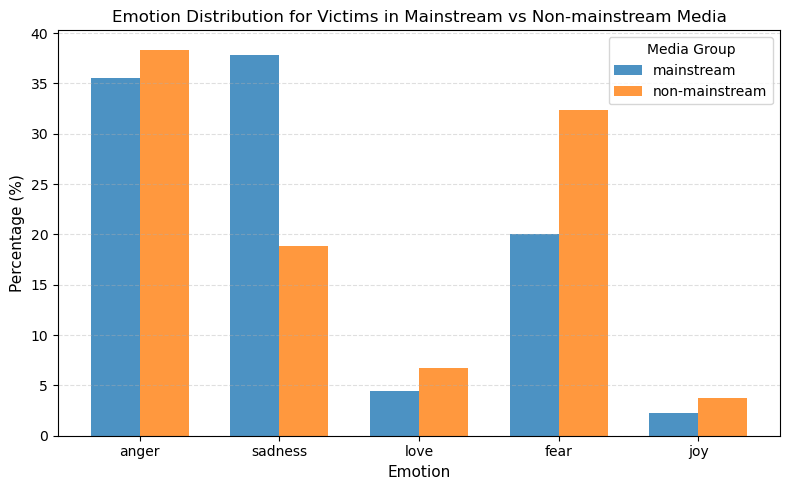

In [300]:
import matplotlib.pyplot as plt
import numpy as np

# 確保情緒順序固定（避免亂序）
emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
media_groups = emotion_counts['media_group'].unique()

# 建立 x 軸位置
x = np.arange(len(emotions))
bar_width = 0.35  # 每個長條寬度

plt.figure(figsize=(8, 5))

for i, group in enumerate(media_groups):
    subset = emotion_counts[emotion_counts['media_group'] == group].set_index('emotion').reindex(emotions).fillna(0)
    plt.bar(x + i * bar_width, subset['percentage'], width=bar_width, label=group, alpha=0.8)

# 美化圖表
plt.title("Emotion Distribution for Victims in Mainstream vs Non-mainstream Media", fontsize=12)
plt.xlabel("Emotion", fontsize=11)
plt.ylabel("Percentage (%)", fontsize=11)
plt.xticks(x + bar_width / 2, emotions)
plt.legend(title="Media Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 文章數 vs. 情緒出現數

In [302]:
# 每個媒體群組的文章數（unique article_id）
article_counts = filtered.groupby('media_group')['article_id'].nunique().reset_index(name='num_articles')

# 每個媒體群組的情緒出現總數
emotion_total = filtered.groupby('media_group').size().reset_index(name='num_emotions')

# 合併比較
summary = pd.merge(article_counts, emotion_total, on='media_group')
summary['emotions_per_article'] = round(summary['num_emotions'] / summary['num_articles'], 2)
summary

,media_group,num_articles,num_emotions,emotions_per_article
0,mainstream,29,45,1.55
1,non-mainstream,91,133,1.46


### 每篇文章出現情緒的覆蓋率

In [304]:
article_level = (
    filtered.groupby(['media_group', 'article_id', 'emotion'])
    .size()
    .reset_index()
)

# 每個媒體群組中，每種情緒出現的文章篇數
article_emotion_counts = (
    article_level.groupby(['media_group', 'emotion'])
    .size()
    .reset_index(name='article_count')
)

# 該媒體總文章數
total_articles = (
    filtered.groupby('media_group')['article_id']
    .nunique()
    .reset_index(name='total_articles')
)

# 合併計算比例
article_emotion_counts = article_emotion_counts.merge(total_articles, on='media_group')
article_emotion_counts['article_ratio'] = round(
    100 * article_emotion_counts['article_count'] / article_emotion_counts['total_articles'], 2
)

article_emotion_counts

,media_group,emotion,article_count,total_articles,article_ratio
0,mainstream,anger,13,29,44.83
1,mainstream,fear,8,29,27.59
2,mainstream,joy,1,29,3.45
3,mainstream,love,2,29,6.90
4,mainstream,sadness,15,29,51.72
5,non-mainstream,anger,43,91,47.25
6,non-mainstream,fear,35,91,38.46
7,non-mainstream,joy,5,91,5.49
8,non-mainstream,love,4,91,4.40
9,non-mainstream,sadness,21,91,23.08


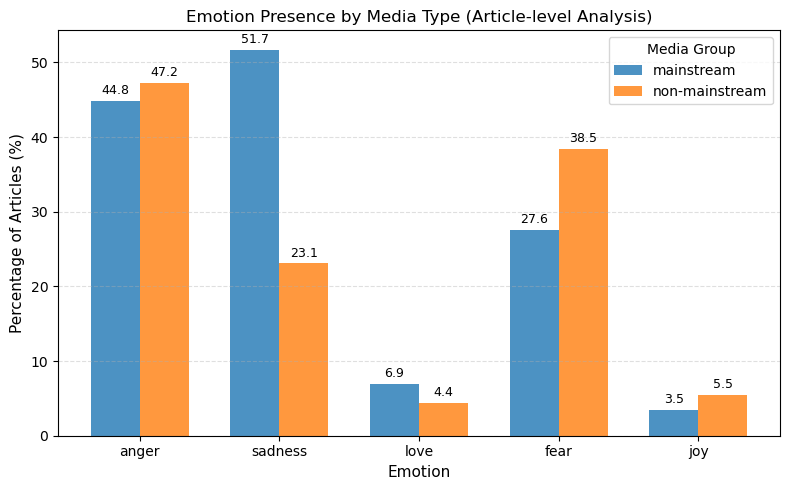

In [305]:
import matplotlib.pyplot as plt
import numpy as np

# 固定情緒順序，讓兩組對齊
emotions = ['anger', 'sadness', 'love', 'fear', 'joy']
media_groups = article_emotion_counts['media_group'].unique()

# x 軸位置
x = np.arange(len(emotions))
bar_width = 0.35

plt.figure(figsize=(8, 5))

for i, group in enumerate(media_groups):
    subset = (
        article_emotion_counts[article_emotion_counts['media_group'] == group]
        .set_index('emotion')
        .reindex(emotions)
        .fillna(0)
    )
    plt.bar(x + i * bar_width, subset['article_ratio'], width=bar_width, label=group, alpha=0.8)

# 加上數值標籤
for i, group in enumerate(media_groups):
    subset = (
        article_emotion_counts[article_emotion_counts['media_group'] == group]
        .set_index('emotion')
        .reindex(emotions)
        .fillna(0)
    )
    for j, val in enumerate(subset['article_ratio']):
        plt.text(x[j] + i * bar_width, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

# 美化圖表
plt.title("Emotion Presence by Media Type (Article-level Analysis)", fontsize=12)
plt.xlabel("Emotion", fontsize=11)
plt.ylabel("Percentage of Articles (%)", fontsize=11)
plt.xticks(x + bar_width / 2, emotions)
plt.legend(title="Media Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 比例檢定（統計顯著性）

#### 文章出現比例

In [308]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

# 建立結果列表
results = []

# 取得所有情緒
emotions = article_emotion_counts['emotion'].unique()

for emo in emotions:
    # 取出該情緒在兩種媒體群組的資料
    sub = article_emotion_counts[article_emotion_counts['emotion'] == emo]

    # 確保順序為 [mainstream, nonmainstream]
    sub = sub.set_index('media_group').reindex(['mainstream', 'non-mainstream'])
    
    count = sub['article_count'].values
    nobs = sub['total_articles'].values

    # 若資料不完整則跳過
    if len(count) < 2 or count[0] == 0 and count[1] == 0:
        continue

    # 執行比例 z 檢定
    z, p = proportions_ztest(count, nobs)

    results.append({
        'emotion': emo,
        'mainstream_ratio': round(100 * count[0] / nobs[0], 2),
        'nonmainstream_ratio': round(100 * count[1] / nobs[1], 2),
        'z_value': round(z, 3),
        'p_value': round(p, 4),
        'significant': 'Yes' if p < 0.05 else 'No'
    })

# 轉成 DataFrame
ztest_results = pd.DataFrame(results)
ztest_results

,emotion,mainstream_ratio,nonmainstream_ratio,z_value,p_value,significant
0,anger,44.83,47.25,-0.228,0.8197,No
1,fear,27.59,38.46,-1.064,0.2875,No
2,joy,3.45,5.49,-0.440,0.6597,No
3,love,6.90,4.40,0.538,0.5905,No
4,sadness,51.72,23.08,2.932,0.0034,Yes


#### 出現總數比例

In [310]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

# 假設 emotion_counts 已經有以下欄位：
# ['media_group', 'emotion', 'count']

results = []

# 取得所有情緒種類
emotions = emotion_counts['emotion'].unique()

for emo in emotions:
    sub = emotion_counts[emotion_counts['emotion'] == emo].set_index('media_group')
    sub = sub.reindex(['mainstream', 'non-mainstream']).fillna(0)

    # 該情緒在不同媒體的出現次數
    count = sub['count'].values

    # 各媒體的總出現次數（母體數 = 該媒體內所有情緒的總次數）
    total = emotion_counts.groupby('media_group')['count'].sum().reindex(['mainstream', 'non-mainstream']).values

    # 若資料不完整則跳過
    if len(count) < 2 or total.sum() == 0:
        continue

    # 比例 z 檢定
    z, p = proportions_ztest(count, total)

    results.append({
        'emotion': emo,
        'mainstream_ratio': round(100 * count[0] / total[0], 2),
        'nonmainstream_ratio': round(100 * count[1] / total[1], 2),
        'z_value': round(z, 3),
        'p_value': round(p, 4),
        'significant': 'Yes' if p < 0.05 else 'No'
    })

# 結果整理
ztest_counts = pd.DataFrame(results)
ztest_counts

,emotion,mainstream_ratio,nonmainstream_ratio,z_value,p_value,significant
0,anger,35.56,38.35,-0.334,0.7384,No
1,fear,20.00,32.33,-1.572,0.1159,No
2,joy,2.22,3.76,-0.494,0.6214,No
3,love,4.44,6.77,-0.559,0.5760,No
4,sadness,37.78,18.80,2.592,0.0095,Yes


## 綜合分析

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 篩選資料 ===
filtered = df[
    (df['entity_type'].isin(source_type_cols)) &
    (df['emotion'].isin(target_emotions))
]

# === 統計各媒體群組、各 entity_type、各情緒的出現次數 ===
emotion_counts = (
    filtered.groupby(['media_group', 'entity_type', 'emotion'])
    .size()
    .reset_index(name='count')
)

# === 計算比例（同一媒體 + 同一 entity_type 內的情緒構成百分比）===
emotion_counts['percentage'] = (
    emotion_counts.groupby(['media_group', 'entity_type'])['count']
    .transform(lambda x: round(100 * x / x.sum(), 2))
)
emotion_counts

,media_group,entity_type,emotion,count,percentage
0,mainstream,business_entities,anger,1,12.50
1,mainstream,business_entities,fear,1,12.50
2,mainstream,business_entities,sadness,6,75.00
3,mainstream,celebrities,anger,17,32.08
4,mainstream,celebrities,fear,7,13.21
...,...,...,...,...,...
90,non-mainstream,victims,anger,214,18.24
91,non-mainstream,victims,fear,364,31.03
92,non-mainstream,victims,joy,16,1.36
93,non-mainstream,victims,love,21,1.79


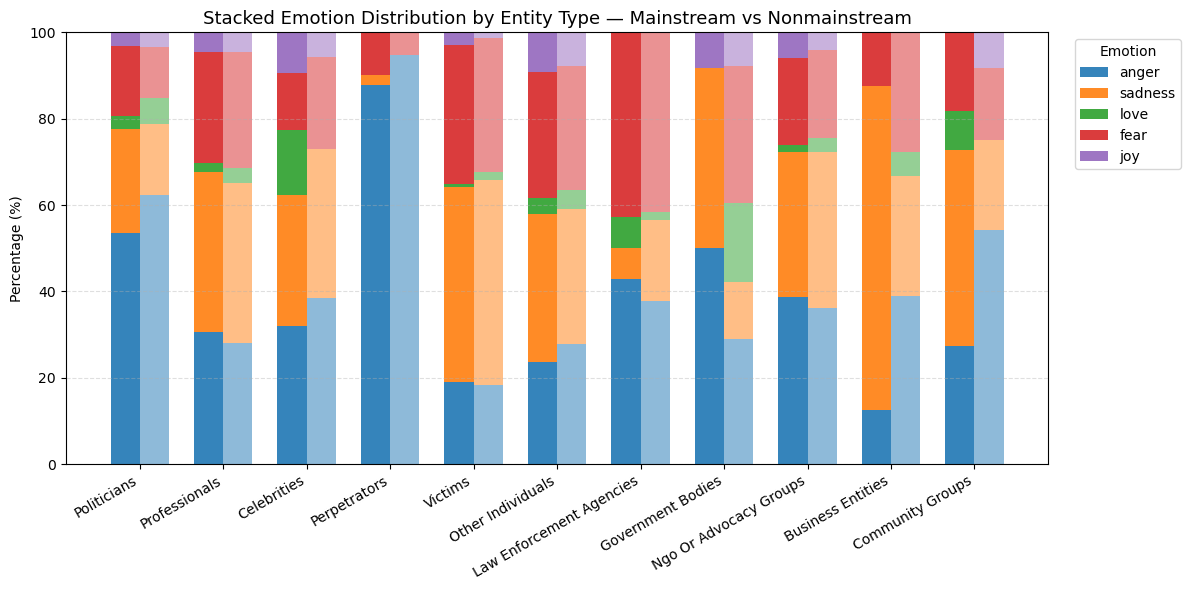

In [355]:
import matplotlib.pyplot as plt
import numpy as np

# === 設定 ===
emotions = target_emotions
media_groups = ['mainstream', 'non-mainstream']
colors = plt.cm.tab10.colors[:len(emotions)]

# === 整理資料 ===
pivot_data = (
    emotion_counts
    .pivot_table(index=['entity_type', 'media_group'], columns='emotion', values='percentage', fill_value=0)
    .reindex(index=pd.MultiIndex.from_product([source_type_cols, media_groups]), fill_value=0)
)

# === 準備 X 軸 ===
x = np.arange(len(source_type_cols))
bar_width = 0.35

plt.figure(figsize=(12, 6))

# === 繪製堆疊長條 ===
for i, group in enumerate(media_groups):
    bottoms = np.zeros(len(source_type_cols))
    for k, emo in enumerate(emotions):
        y = [pivot_data.loc[(ent, group), emo] for ent in source_type_cols]
        plt.bar(
            x + i * bar_width ,
            y,
            width=bar_width,
            bottom=bottoms,
            color=colors[k],
            alpha=0.5 if group == 'non-mainstream' else 0.9,
            label=f"{emo}" if i == 0 else None
        )
        bottoms += y

# === 格式與標籤 ===
plt.xticks(x + bar_width / 2, [ent.replace('_', ' ').title() for ent in source_type_cols], rotation=30, ha='right')
plt.ylabel("Percentage (%)")
plt.title("Stacked Emotion Distribution by Entity Type — Mainstream vs Nonmainstream", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Emotion", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()